In [149]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display
import csv
import geopy
from pathlib import Path  
import sys
from bs4 import BeautifulSoup
import urllib
import json
import ast
import time
import geopandas as gpd
import snscrape.modules.twitter as sntwitter

import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amer_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [150]:
# Authentication
consumerKey = "jLsJDtWU8yD5tZlcmwlzYnGjj"
consumerSecret = "Y236WRUhs5ylGfcZwjmabwPRWwedThHVB8gFVBPC3oTNAbRnCz"
accessToken = "964316780993933313-ZJOdE1MRMA8WyqZoNajtj0EWy4KQVDI"
accessTokenSecret = "qMOuqbyZmKXQTVXGFofwriLZpZn5zAAwGjsw0Wlft7M0a"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit = True)
file_dir = Path.cwd()

In [151]:

# The below function takes a given state, and returns a dataframe with every county and its corresponding square milage
def county_sqFootage(state):
	state = re.sub(' ', '-', state)
	url = urllib.request.urlopen('http://www.usa.com/rank/' +state.lower() + '-state--land-area--county-rank.htm')
	path = url.read()
	# empty list
	data = []
	# for getting the header from
	# the HTML file
	list_header = []
	soup = BeautifulSoup((path),'html.parser')
	header = soup.find_all("table")[1].find("tr")
	for items in header:
		try:
			list_header.append(items.get_text())
		except:
			continue
	# for getting the data
	HTML_data = soup.find_all("table")[1].find_all("tr")[1:]
	for element in HTML_data:
		sub_data = []
		for sub_element in element:
			try:
				sub_data.append(sub_element.get_text())
			except:
				continue
		data.append(sub_data)
	# Storing the data into Pandas
	# DataFrame
	df = pd.DataFrame(data = data, columns = list_header)
	df.drop(df.columns[[0]],axis = 1,inplace = True)
	df.rename(columns = {'County / Population':'County','Land Area ▼':'Area'}, inplace = True)
	# Removing the section of the data for population information and deleting it
	formatdf= df['County'].str.split(',',expand = True)
	formatdf = formatdf[0]
	# recombining the data
	df = df['Area'].str.split(' sq', expand = True)
	df = df.replace({',':''}, regex=True)	
	df = df[0]
	df= pd.concat([df,formatdf],axis=1,join = 'inner')
	df.columns = ['Area','County']
	df['County']=df['County'].str.upper()
	df['Radius'] = df['Area'].astype(float)
	df['Radius'] = df['Radius'].apply(lambda x: (x/3.1415)**.5)
	# Search Radius is what the Twitter API will end up using
	return df	

	# Main code logic copied from Codegeeks https://www.geeksforgeeks.org/convert-html-table-into-csv-file-in-python/



In [152]:
def create_wordcloud(text,keyword):
    file_path = os.path.join(file_dir, 'Keyword State')
    mask = np.array(Image.open('cloud.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    name = (state) + " on the term " + keyword+ ".png"
    path= os.path.join(file_path,name)
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    display(Image.open(path))

In [153]:

def getCountyInfo(state):
    
    csv_folder = 'State information'
    file_path = os.path.join(file_dir, csv_folder, (state+'.csv'))
    print((Path.cwd() / csv_folder /(state+'.csv')).exists())    
    if((Path.cwd() / csv_folder /(state+'.csv')).exists()):
        data = pd.read_csv(file_path)
    else:
        print('boop')
        # make a program that uses this dataset https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv
        # to get all the cities in a state
        data = pd.read_csv('https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv',sep='|')
        del data['State short'], data['City'],data['City alias']
        data.columns = data.columns.str.replace('State full', 'State')
        data = data[data.State == state]
        data.drop_duplicates(subset='County', keep='first', inplace=True)
        del data['State']
        coordinates = []
        for county in data['County']:
            print(county)
            locator = geopy.Photon(user_agent="myGeocoder")
            location = locator.geocode(county.lower() + ',' + state + ', United States')
            # Make a new column in my dataframe with the lat and long
            coordinates.append([location.latitude,location.longitude])
        data['Coordinates'] = coordinates
        area = county_sqFootage(state)
        data = pd.merge(data,area, on= 'County', how = 'outer')
        data.rename(columns = {'Area':'Area (sq/mi)','Radius':'Radius (mi)'}, inplace = True)
        data.to_csv(file_path)
    return data



In [154]:
def pullTweets(keyword,geocode,noOfTweet):
    tweets_list2 = []
    for j,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword + ' '+ geocode).get_items()):
        tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
        if j == noOfTweet-1:
            return tweets_list2
    return tweets_list2

In [155]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)
noOfTweet = 4000
state = 'Texas'
countyDF =  (getCountyInfo(state))
keyword = 'Transgender'
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
cityDict = {}
json_folder = 'Keyword State'
file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
def average(arr):
    return (sum(arr) / len(arr))
# extract the county collumn from the countyDF and convert its values to a list
countyList = countyDF['County'].values.tolist()
usefulTweets = 0
users = []
county_needed = []
tweets_list2 = []

# if file_path exists, set the county_needed list equal to all the items from the county list not present in the keys of the json
total_data = []
if((Path.cwd() / json_folder /(((state) + " on the term " + keyword +'.json'))).exists()):
    f = open(file_path, 'r')
    cityDict = json.load(f)
    checked_counties = cityDict.keys()
    # set county_needed equal to the items in county that aren't present in checked_counties
    county_needed = countyList-checked_counties
    print(county_needed)
    # for county in cityDict:
    #     tweet_list = tweet_list + cityDict[county][2]
    # Old code for then the third index corresponded to cached tweets
    print(len(tweet_list))


else:
    county_needed = countyList
for county in county_needed:
    coordinates = (countyDF.loc[countyDF['County'] == county]['Coordinates'])
    coordinates = np.array(coordinates.values.tolist())[0]
    coordinates = ast.literal_eval(coordinates)
    lat = coordinates[0]
    longi = coordinates[1]
    miles = [countyDF.loc[countyDF['County'] == county]['Radius (mi)'].values[0]][0]
    geocode = 'geocode:' + str(coordinates[0]) + ',' + str(coordinates[1]) + ',' + str(miles) + 'mi'

    tweets_list2 = pullTweets(keyword,geocode,noOfTweet)
    # One of the issues found was that due to the repeated run command, this would have trouble breaking on its own
    # Thus I wrote it into a function that would break and return the needed data at the limi
    tweets_df = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
    location = county
    if location not in cityDict.keys():
        cityDict[location] = [0,[],[]]
    for index,tweet in tweets_df.iterrows():
        # location = tweet.user.location
        
        username = tweet['Username']
        cityDict[location][0]+=1
        tweetText = tweet['Text']

        
        analysis = TextBlob(tweetText)
        score = SentimentIntensityAnalyzer().polarity_scores(tweetText)
        # SCORE RETURNING IS FINE
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        # comp variable still works

        # ISSUE IS WITH UP HERE!!!
        if (username not in users) and (tweetText not in tweet_list):
            usefulTweets+=1
            polarity += analysis.sentiment.polarity
            cityDict[location][1].append(comp)
            if neg > pos:
                negative_list.append(tweetText)
                negative += 1
            elif pos > neg:
                positive_list.append(tweetText)
                positive += 1
            
            elif pos == neg:
                neutral_list.append(tweetText)
                neutral += 1
            users.append(username)
            tweet_list.append(tweetText)
        # save the cityDict to a json file at directory file_path
        with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
    print("For the county of " + str(county) + ", there were " + str(cityDict[location][0]) + " unique tweets")
    cityDict[county].pop(2)
    if(len(cityDict[county][1]) > 0):
        cityDict[county][1] = sum(cityDict[county][1])/len(cityDict[county][1])
        print(cityDict[county][1])
    else:
        print(county + ' returned no tweets')
        cityDict.pop(county)

    
    # delete the second index of cityDIct
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
# fully expand all lower levels of the list to the first level
tweet_list = list(set(tweet_list))
print(len(tweet_list))
with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
# make a new dictionary identical to countyDict but without the second index



True
{'HALL', 'JEFF DAVIS', 'KENT', 'WISE', 'JACKSON', 'LYNN', 'THROCKMORTON', 'LAMAR', 'BOSQUE', 'OLDHAM', 'FISHER', 'ATASCOSA', 'WILBARGER', 'DEAF SMITH', 'FLOYD', 'TYLER', 'REFUGIO', 'KNOX', 'ANDREWS', 'ZAVALA', 'HASKELL', 'EDWARDS', 'NOLAN', 'LEON', 'CASS', 'KIMBLE', 'MCMULLEN', 'KARNES', 'GARZA', 'MILAM', 'GONZALES', 'YOAKUM', 'SAN SABA', 'MCCULLOCH', 'REAGAN', 'MILLS', 'HARDEMAN', 'KENEDY', 'DIMMIT', 'EASTLAND', 'TERRELL', 'WILLACY', 'IRION', 'DICKENS', 'HANSFORD', 'LA SALLE', 'MARION', 'FOARD', 'GOLIAD', 'HENDERSON', 'DELTA', 'ERATH', 'JIM HOGG', 'GLASSCOCK', 'ARMSTRONG', 'REAL', 'FANNIN', 'SHELBY', 'HAMILTON', 'JACK', 'ROBERTS', 'CULBERSON', 'HUDSPETH', 'VAL VERDE', 'SCHLEICHER', 'PARMER', 'HARDIN', 'DONLEY', 'COOKE', 'STERLING', 'HALE', 'COKE', 'TERRY', 'LIVE OAK', 'RED RIVER', 'PALO PINTO', 'ROBERTSON', 'CASTRO', 'BURLESON', 'MARTIN', 'LIPSCOMB', 'HEMPHILL', 'SABINE', 'VAN ZANDT', 'CROCKETT', 'COLLINGSWORTH', 'MITCHELL', 'BAYLOR', 'OCHILTREE', 'UVALDE', 'JONES', 'DUVAL', 'COC

KeyboardInterrupt: 

In [ ]:


positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
print(cityDict)
print('---')
# remove duplicates from tweet_list
# Function got too chambers before hitting rate limit

{'TRAVIS': [1466, 0.014952997275204358], 'SHERMAN': [1, 0.7391], 'DALLAS': [2626, -0.018511990407673876], 'COLLIN': [73, 0.011615384615384618], 'DENTON': [33, 0.07559999999999997], 'ROCKWALL': [20, 0.2175], 'ELLIS': [1, 0.0], 'KAUFMAN': [7, 0.16879999999999998], 'HUNT': [1, -0.4939], 'CAMP': [2, 0.24735], 'TITUS': [1, -0.743], 'BOWIE': [15, -0.01611428571428573], 'MORRIS': [1, 0.0], 'GREGG': [24, 0.019752631578947365], 'UPSHUR': [1, -0.3182], 'HARRISON': [9, 0.504], 'RUSK': [1, -0.5574], 'SMITH': [47, -0.127172], 'CHEROKEE': [1, -0.2411], 'NACOGDOCHES': [20, 0.23707499999999998], 'ANDERSON': [4, 0.0], 'HOUSTON': [1816, 0.0015718257645968433], 'FREESTONE': [1, 0.3885], 'ANGELINA': [4, 0.0], 'NEWTON': [1, -0.69], 'POLK': [22, -0.2432285714285714], 'TARRANT': [1965, -0.0003865051903114084], 'PARKER': [2, 0.6101], 'JOHNSON': [4, -0.0726], 'HOOD': [9, 0.0312666666666667], 'SOMERVELL': [1, 0.0], 'HILL': [1, -0.5994], 'CLAY': [64, -0.14399428571428574], 'WICHITA': [29, -0.1474391304347826], '

In [ ]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  77
positive number:  32
negative number:  27
neutral number:  18


In [ ]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(tweet_list.shape[0])

,0,text
0,Celebrating Our Veterans and Recognizing Trans...,celebrating our veterans and recognizing trans...
1,Transgender? https://t.co/NfXerizoHH,transgender
2,Plus size women and transgender women will alw...,plus size women and transgender women will alw...
3,#RealMan don't say you would kill a transgende...,realman don t say you would kill a transgende...
4,@realDonaldTrump : Transgender is pre-existing...,transgender is pre existing just like hi...
...,...,...
72,( update on book liveing life as transgender m...,update on book liveing life as transgender m...
73,we tend to forget that White males hold privil...,we tend to forget that white males hold privil...
74,Hope for Texas: Baptist preacher calls on the ...,hope for texas baptist preacher calls on the ...
75,NBC News showing this horrible woman referring...,nbc news showing this horrible woman referring...


In [ ]:
print(cityDict)

{'TRAVIS': [1466, 0.014952997275204358], 'SHERMAN': [1, 0.7391], 'DALLAS': [2626, -0.018511990407673876], 'COLLIN': [73, 0.011615384615384618], 'DENTON': [33, 0.07559999999999997], 'ROCKWALL': [20, 0.2175], 'ELLIS': [1, 0.0], 'KAUFMAN': [7, 0.16879999999999998], 'HUNT': [1, -0.4939], 'CAMP': [2, 0.24735], 'TITUS': [1, -0.743], 'BOWIE': [15, -0.01611428571428573], 'MORRIS': [1, 0.0], 'GREGG': [24, 0.019752631578947365], 'UPSHUR': [1, -0.3182], 'HARRISON': [9, 0.504], 'RUSK': [1, -0.5574], 'SMITH': [47, -0.127172], 'CHEROKEE': [1, -0.2411], 'NACOGDOCHES': [20, 0.23707499999999998], 'ANDERSON': [4, 0.0], 'HOUSTON': [1816, 0.0015718257645968433], 'FREESTONE': [1, 0.3885], 'ANGELINA': [4, 0.0], 'NEWTON': [1, -0.69], 'POLK': [22, -0.2432285714285714], 'TARRANT': [1965, -0.0003865051903114084], 'PARKER': [2, 0.6101], 'JOHNSON': [4, -0.0726], 'HOOD': [9, 0.0312666666666667], 'SOMERVELL': [1, 0.0], 'HILL': [1, -0.5994], 'CLAY': [64, -0.14399428571428574], 'WICHITA': [29, -0.1474391304347826], '

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
        tw_list.loc[index, 'neg'] = neg
        tw_list.loc[index, 'neu'] = neu
        tw_list.loc[index, 'pos'] = pos
        tw_list.loc[index, 'compound'] = comp
tw_list.head(10)
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [ ]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
positive,32,41.56
negative,28,36.36
neutral,17,22.08


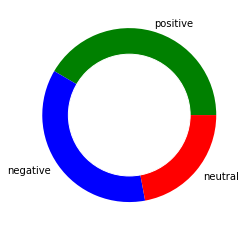

In [ ]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Word Cloud Saved Successfully


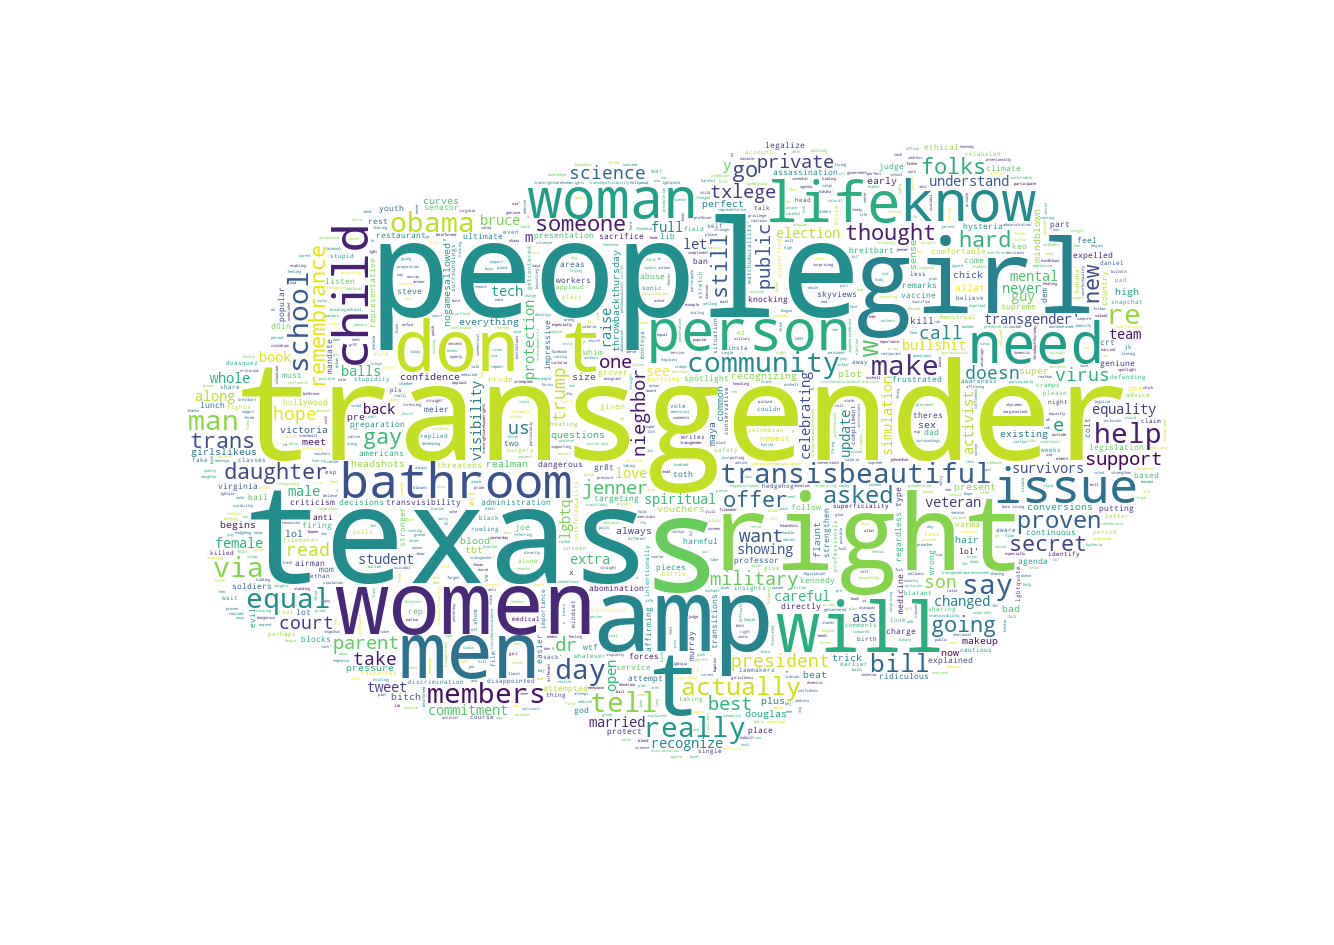

In [ ]:
cloud = create_wordcloud(tw_list['text'].values,keyword)
# save the wordcloud image


In [174]:
from matplotlib import colors
import matplotlib.cm as cm

def mapStateData(state,keyword):
    json_folder = 'Keyword State'
    # keyword = 'gay'
    file_dir = Path.cwd()
    file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
    name = ((state) + " on the term " + keyword +'.json')
    unitedStates = gpd.read_file(shape_dir)
    unitedStates = unitedStates[['STATE_NAME','NAME','geometry']].copy()
    unitedStates = unitedStates[unitedStates.STATE_NAME == state]
    unitedStates['NAME'] = unitedStates['NAME'].str.upper()
    unitedStates.rename(columns={'NAME':'County'}, inplace=True)
    # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
    f = open(file_path, 'r')
    state_dict = json.load(f)
    stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
    stateDF.reset_index(inplace=True)
    # stateDF = stateDF[[0,1,2]]

    stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score'}, inplace=True)
    # stateDF = stateDF.drop(['dead'],1)
    # pd.DataFrame(stateDF["score"].to_list(), columns=['score'])


    score = []
    j=0
    for value in stateDF['score']:
        if(isinstance(value,float)==False):
            stateDF=stateDF.drop(stateDF.index[[j]])
        j+=1
    j=0
    for value in stateDF['score']:
        if(isinstance(value,float)==False):
            stateDF=stateDF.drop(stateDF.index[[j]])
        j+=1
    stateDF['score'] = stateDF['score'].astype(float)
    unitedStates = pd.merge(unitedStates,stateDF, on= 'County', how = 'outer')
    cm1 = colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])

    # Make a normalizer that will map the time values from

    # Turn these into an object that can be used to map time values to colors and
    norm = colors.TwoSlopeNorm(vmin=-.4, vcenter=0, vmax=.4)
    fig.set_size_inches(9, 3)
    title = (state + " on the term \"" + keyword +"\"" )
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()
    ax1 = unitedStates.plot(ax = ax1,cmap = cm1, norm= norm,edgecolor='black',column = 'score',legend = True, legend_kwds={'label':'Sentiment Score','orientation':'vertical'})
    # Something is wrong with the score column
    title1 = ('Sentiment')
    ax1.set_title(title1)
    ax1.set_axis_off()   
    max = int(stateDF.iloc[:, 1].max())
    print(max)
    norm2 = colors.PowerNorm(gamma = .4,vmin=0,vmax=max)
    ax2 = unitedStates.plot(ax=ax2,cmap = 'OrRd',norm = norm2,edgecolor='black',column = '# of Tweets',legend = True, legend_kwds={'label':'# of Tweets','orientation':'vertical'})
    title2 = ('# Of Unique Tweets')
    ax2.set_title(title2)
    ax2.set_axis_off()
    save_dir=os.path.join(file_dir, 'Maps', state)

    if(os.path.isdir(save_dir)):
        save_name = os.path.join(file_dir, 'Maps', state,keyword +'.png')
    else:
        # make a directory in the maps folder with the name of the given state
        os.mkdir(save_dir)
        save_name = os.path.join(file_dir, 'Maps', state,keyword +'.png')
    # save the figure to the maps folder inside the folder corresponding to the state

    plt.savefig(save_name,dpi=300,facecolor='white', transparent=False)



C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.p

4000


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __le

2626


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __le

8000


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


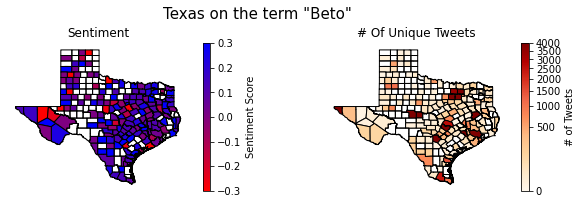

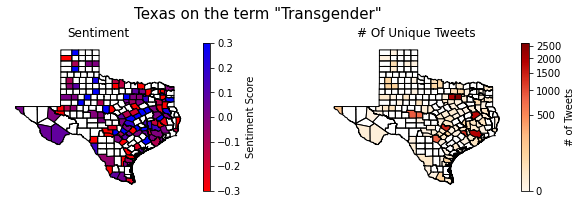

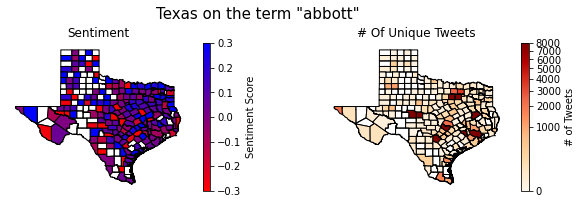

In [176]:
mapStateData(state,'Beto')
mapStateData(state,'Transgender')
mapStateData(state,'abbott')

In [ ]:
def refreshMaps():
    folders = (os.path.join(file_dir,'Maps'))
    subfolders =os.listdir(folders)
    print(subfolders)
    for state in subfolders:
        print(state)
        path = os.path.join(file_dir, 'Maps', state)
        files = os.listdir(path)
        for f in files:
            f = f[:-4]
            mapStateData(state,f)